# The Euler-Bernoulli beam model

Model: 2D beam reduced to 1D problem. We study the deformation of the midplane under the assumptions that after the deformation the normals to the midplane:

* do not bend
* do not stretch
* remain orthogonal to the midplane.

This theory is adequate for thin beams and is intended for small strains even with large global deformations: it is a physically linear but geometrically non-linear theory.

For thicker beams, Timoshenko's theory, which accounts for internal shear forces, yields more accurate predictions.

Fix $\omega = (a, b)$ to be the midplane of the beam $\Omega = \omega \times
(- h / 2, h / 2) \subset \mathbb{R}^2$.

## Derivation

Ad-hoc stuff … compute … hack … compute … and:

$$\frac{\mathrm{d}^2}{\mathrm{d} x^2} \left( b(x) \frac{\mathrm{d}^2}{\mathrm{d} x^2}u(x) \right) = f$$

where $b(x) = E(x) I(x)$ is the product of Young's modulus $E$ and the area moment of inertia of the beam $I$. For a steel beam (with < 0.3% carbon) at 21°C, $E = 203.4 \cdot 10^9 \text{Pa}$ and if it has a constant square cross section of side 0.01m, then $I=8 \cdot 10^{-10}$.


## Weak formulation

Write $\nabla u = \frac{\mathrm{d}}{\mathrm{d} x} u$ and $\Delta u =
\frac{\mathrm{d}^2}{\mathrm{d} x^2} u$. Let $V$ be a subspace of $H^2
(\Omega)$ to be specified later. Multiplying the equation by a
test function $v \in V$ and integrating by parts we arrive at

$$ \int_{\Omega} b \Delta u \Delta v \mathrm{d} x - [b \Delta u \nabla v]_a^b
   + [\nabla (b \Delta u) v]_a^b = \int_{\Omega} fv \mathrm{d} x. $$

In order for these integrals to make sense we may take $b \in L^{\infty}
(\Omega)$ and $f \in L^2 (\Omega)$ (or even $H^{- 2} (\Omega)$). The
definition of $V$ and the final form of the equation are determined by our
choices for the four boundary conditions that have to be specified:

**Essential boundary conditions:** We fix either the
**deflections** $u (\alpha)$ or the **slopes** $u' (\alpha)$
or both at the ends of the beam $\alpha \in \{a, b\}$. These conditions are
incorporated into the definition of $V$. For example if we **clamp**
the beam at an horizontal position we have

$$ V = V_{\text{clamped}} = \{ v \in H^2 (\Omega) : v (\alpha) = v_{\alpha},
   v' (\alpha) = v'_{\alpha}, \alpha = 1, 2 \} . $$

**Natural boundary conditions:** For $\alpha \in \{a, b\}$, we can fix
the **bending moment**:

$$ M (\alpha) = (b \Delta u) (\alpha), $$

which for general $x \in \Omega$ is the torque exerted by forces surrounding
$x$. If, for example we find solutions such that $M (a) = 0$, then we are
assuming that the left end of the beam is free to rotate, i.e. that it
undergoes no bending due to torque. Alternatively we can set the
**shear force** at $\alpha$:

$$ F (\alpha) = [\nabla (b \Delta u)] (\alpha), $$

which is the resultant of transversal forces at $x \in \Omega$. This will in
general be zero at the ends.

If we set $\Gamma_M, \Gamma_F \subset \{ a, b \}$, after choosing some
combination of the conditions the problem is: Find $u \in V$ such that for all
$v \in V$:

$$ \int_{\Omega} b \Delta u \Delta v \mathrm{d} x = \int_{\Omega} fv
   \mathrm{d} x + \int_{\Gamma_M} M \nabla v \mathrm{d} s - \int_{\Gamma_F} Fv
   \mathrm{d} s $$
   
$V, \Gamma_M, \Gamma_F$ to be (consistently) specified.

## Discretization

Recall that $H^2(a,b) \in C^1(a,b)$ by the Sobolev embeddings.

Even though cuadratic polynomials might be enough, we want to construct a Ciarlet finite element, i.e. need unisolvent set of degrees of freedom, which requires at least cubic polynomials ... [elaborate, see p.218 of ...]

Use Cubic Hermite elements => $H^2$ conforming in $\mathbb{R}$.

# Common code

Because we will be doing several examples it is convenient to factor out most of the stuff. The resulting code is somewhat ugly, with a nasty mixture of global state and unintuitive parameters, but elegance is not the point here.

In [1]:
from dolfin import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl

# Beam and problem parameters. Assume an homogenous steel beam of constant cross-section
E = 203.4e9  # Steel (< 0.3% carbon) @ 21°C ~ 203.38 GPa
I = 8e-10    # Second moment of inertia / area (in m^4, for square beam of side 0.01m)
g = 9.8      # Gravity m/s^2

# Basic setup
mesh = UnitIntervalMesh(200)
V = FunctionSpace(mesh, "Hermite", 3)
b = Constant(E*I) # HACK

class right_subdomain(SubDomain):
    """ Right end of the beam. """
    def inside(self, x, on_boundary):
        return on_boundary and np.isclose(x[0], 1.)

class left_subdomain(SubDomain):
    """ Left end of the beam. """
    def inside(self, x, on_boundary):
        return on_boundary and np.isclose(x[0], 0.)

# We will use this to mark boundaries for natural boundary conditions
exterior_facet_domains = FacetFunction("uint", mesh)
exterior_facet_domains.set_all(1)

In [87]:
def solve_with_bcs(essential_bcs, natural_bcs=None, external_force=None):
    """ Sets up and solves the beam problem for the given boundary conditions.
    Arguments:
        essential_bcs: either one DirichletBC or an array of them.
        natural_bcs: a tuple of ufl Forms (b,b') representing:
                     b: additional terms for the bilinear form a()
                     b': additional terms for the right hand side
        external_force: gravity is used if set to None."""
    if natural_bcs is None:
        natural_bcs = [None, None]
    u = TrialFunction(V)
    v = TestFunction(V)

    f = Constant(-g) if external_force is None else external_force
    a = b * inner(u.dx(0).dx(0), v.dx(0).dx(0))*dx
    if natural_bcs[0] is not None:
        a = a + natural_bcs[0]
    
    L = inner(f, v)*dx 
    if natural_bcs[1] is not None:
        L = L + natural_bcs[1]
    
    u = Function(V)
    solve(a==L, u, bcs=essential_bcs)
    
    return u

In [88]:
def plot_beam(solution, beam_width=0.01, magnification=1.0):
    """ Draws the deformed beam and its midplane. 
    Arguments:
        beam_width: """
    xx = mesh.coordinates().flatten()
    u = solution.compute_vertex_values(mesh) * magnification
    offset = beam_width / 2
    pl.plot(xx, u, c='brown')
    pl.plot(xx, u-offset, c='brown', lw=0.5)
    pl.plot(xx, u+offset, c='brown', lw=0.5)
    pl.ylabel("%s deflection" % ("%.1f *" % magnification if magnification != 1. else ""))
    pl.xlabel("x")
    pl.ylim(-beam_width+(np.min(u)-offset)*2, beam_width*5)

# Plug-in test

To test the code we assume a deflection given by $u(x)=-\frac{x^4}{16}$ and constant $b(x) = E I$ over the interval $(a,b) = (0,1)$. Substituting into the equation this yields a right hand side $f(x) = - \frac{3}{2} E I$.

For the boundary conditions we see that the left side of the beam has $u(0)=u'(0)=0$, which we include into the essential boundary conditions for the solution space. At the opposite side of the beam we have $M_b = E I u''(1) = - \frac{3}{4} E I $,  $F_b = E I u'''(1) = - \frac{3}{2} E I$.

Computing the solution over a grid with 100 elements yields an error of roughly $4.8 \cdot 10^{-11}$ (in the sup norm).

Maximum error = 1.144010e-09


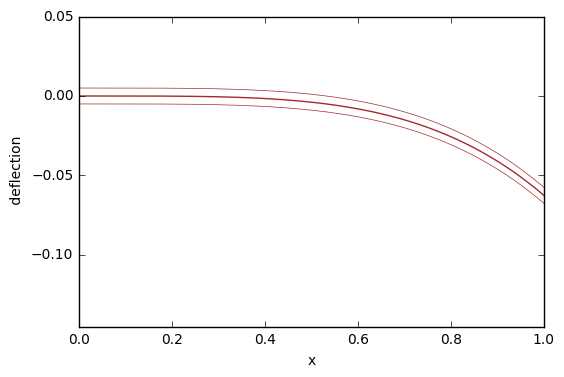

In [89]:
natural_boundary = right_subdomain()
natural_boundary.mark(exterior_facet_domains, 0)
ds = ds(subdomain_data=exterior_facet_domains)

boundary_moment = Constant(-0.75*E*I)
boundary_shear = Constant(-1.5*E*I)
v = TestFunction(V)
u = solve_with_bcs(essential_bcs    = DirichletBC(V, Constant(0.), left_subdomain()),
                   natural_bcs = [None, inner(boundary_moment, v.dx(0))*ds(0) - 
                                        inner(boundary_shear, v)*ds(0)],
                   external_force   = Constant(-1.5*E*I))
plot_beam(u)

xx = mesh.coordinates().flatten()
print("Maximum error = %e" % 
      np.linalg.norm(u.compute_vertex_values(mesh) - (-(xx**4)/16), np.inf))

# Clamped beam

We look for a solution with clamped boundaries, i.e. $u(a)=u(b)=u'(a)=u'(b)=0$. Because of the essential constraints, the terms corresponding to the natural ones in the weak formulation vanish and we are left with:

$$ V = V_{\text{clamped}} = \{ v \in H^2 (\Omega) : v (\alpha) = v_{\alpha},
   v' (\alpha) = v'_{\alpha}, \alpha = 1, 2 \} . $$
   
and $\Gamma_M = \Gamma_F = \emptyset$.

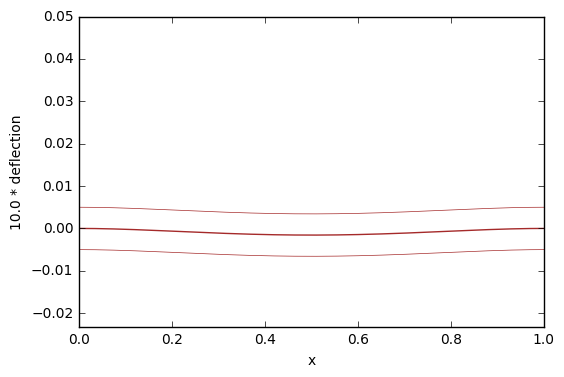

In [90]:
essential_bcs = [DirichletBC(V, Constant(0.), left_subdomain()),
                 DirichletBC(V, Constant(0.), right_subdomain())]
u = solve_with_bcs(essential_bcs)
plot_beam(u, magnification=10)

# Cantilevered beam

One boundary is clamped, e.g. $u(a)=u'(a)=0$, and the other is left hanging freely, so that no bending moment (i.e. no torque) and no shear force appear, e.g. assuming constant $E$ and $I$: $u''(b)=u'''(b)=0$.

We can generalise this to the case where we hang a mass from the free end of the beam. The downward force will introduce shear, e.g. $u'''(b) = - m g$, with $m$ the mass of the object and $g$ gravity. Just set $m=0$ for the first situation.

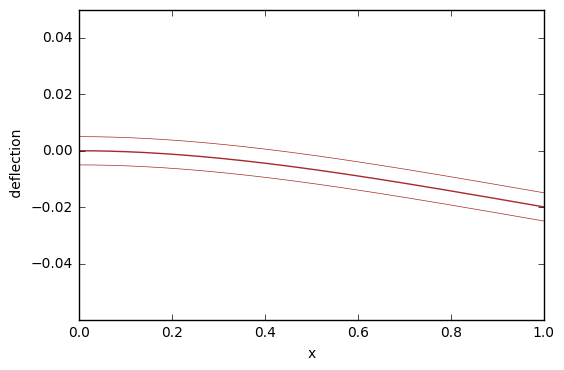

In [91]:
# Kg of mass hanging from the right end, set to zero for a free end
m = 100

# Cantilever BCs: 0 bending and shear = -m*g at the right side
natural_boundary = right_subdomain()
natural_boundary.mark(exterior_facet_domains, 0)
ds = ds(subdomain_data=exterior_facet_domains)

boundary_moment = Constant(0)
boundary_shear = Constant(m*g/(E*I))

v = TestFunction(V)
u = solve_with_bcs(essential_bcs = DirichletBC(V, Constant(0.), left_subdomain()),
                   natural_bcs   = [None, inner(boundary_moment, v.dx(0))*ds(0) -
                                          inner(boundary_shear, v)*ds(0)])
plot_beam(u)

# Simply supported beam (wrong!)

The beam rests on two point supports at its ends. Displacements are fixed at both ends with $u(a)=u(b)=0$, but since the beam is free to rotate, it experiences no torque at these points, i.e. the bending moments are zero: $u''(a)=u''(b)=0$, so we can plug in the natural boundary condition $M=0$ and the problem is: Find $u \in V = H^2_0(\omega)$ such that for all $v \in V$:

$$ \int_{\omega} b \Delta u \Delta v \mathrm{d} x + \int_{\gamma} \nabla (b \Delta u) v 
\mathrm{d} s = \int_{\omega} fv \mathrm{d} x. $$

This means we need to change the bilinear form $a$ in the problem setting, and in our hackish setup we do this by setting the first element of `natural_bcs` in the call to `solve_with_bcs`.

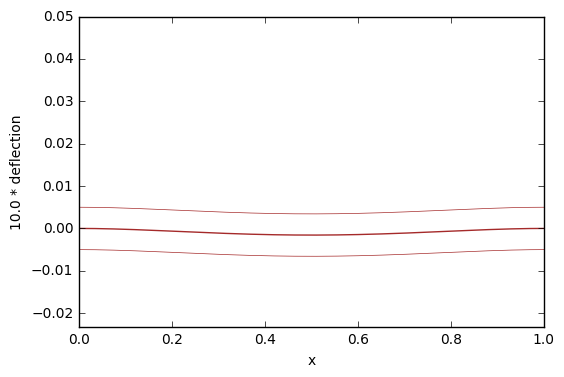

In [97]:
# FIXME? Is it ok to define a form with new variables u,v, 
# then add it to a() in solve_with_bcs?
u = TrialFunction(V)
v = TestFunction(V)
u = solve_with_bcs(essential_bcs = [DirichletBC(V, Constant(0.), left_subdomain()),
                                    DirichletBC(V, Constant(0.), right_subdomain())],
                   natural_bcs   = [inner((b*u.dx(0).dx(0)).dx(0), v)*ds, None]) 
plot_beam(u, magnification=10)

In [98]:
bla = assemble(inner((b*u.dx(0).dx(0)).dx(0), v)*ds)

    Calling FFC just-in-time (JIT) compiler, this may take some time.
      MBD: Assuming all mappings to be hermite in _get_auxiliary_variables()
Transformation is not supported: 'hermite'


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to perform just-in-time compilation of form.
*** Reason:  ffc.jit failed with message:
Traceback (most recent call last):
  File "/home/fenics/local/lib/python2.7/site-packages/dolfin/compilemodules/jit.py", line 128, in jit
    result = ffc.jit(ufl_object, parameters=p)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/jitcompiler.py", line 198, in jit
    module = jit_build(ufl_object, module_name, parameters)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/jitcompiler.py", line 120, in jit_build
    generate=jit_generate)
  File "/home/fenics/local/lib/python2.7/site-packages/dijitso/jit.py", line 160, in jit
    header, source, dependencies = generate(jitable, name, signature, params["generator"])
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/jitcompiler.py", line 66, in jit_generate
    prefix=module_name, parameters=parameters, jit=True)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/compiler.py", line 141, in compile_form
    prefix, parameters, jit)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/compiler.py", line 188, in compile_ufl_objects
    ir = compute_ir(analysis, prefix, parameters, jit)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/representation.py", line 190, in compute_ir
    for (form_id, fd) in enumerate(form_datas)]
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/representation.py", line 453, in _compute_integral_ir
    parameters)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturerepresentation.py", line 101, in compute_integral_ir
    cell)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturerepresentation.py", line 185, in _transform_integrals_by_type
    integral_type)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturerepresentation.py", line 223, in _transform_integrals
    terms = transformer.generate_terms(integral.integrand(), integral_type)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 763, in generate_terms
    terms = self.visit(integrand)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 104, in visit
    r = h(o, *[self.visit(op) for op in o.ufl_operands])
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 514, in indexed
    code = self.visit(indexed_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 718, in component_tensor
    code = self.visit(component_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 104, in visit
    r = h(o, *[self.visit(op) for op in o.ufl_operands])
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 514, in indexed
    code = self.visit(indexed_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 718, in component_tensor
    code = self.visit(component_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 514, in indexed
    code = self.visit(indexed_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 430, in grad
    code = self.visit(derivative_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 430, in grad
    code = self.visit(derivative_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 430, in grad
    code = self.visit(derivative_expr)
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/algorithms/transformer.py", line 108, in visit
    r = h(o)
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformerbase.py", line 480, in coefficient
    self.gdim, self.avg)}
  File "/home/fenics/local/lib/python2.7/site-packages/ffc/quadrature/quadraturetransformer.py", line 773, in create_function
    error("Transformation is not supported: " + repr(transformation))
  File "<string>", line 1, in <lambda>
  File "/home/fenics/local/lib/python2.7/site-packages/ufl/log.py", line 171, in error
    raise self._exception_type(self._format_raw(*message))
Exception: Transformation is not supported: 'hermite'
.
*** Where:   This error was encountered inside jit.py.
*** Process: 0
*** 
*** DOLFIN version: 2017.1.0.dev0
*** Git changeset:  8d4c7c807451f2301020ec23a2106f0501c632e3
*** -------------------------------------------------------------------------


### Debugging history

**The solution looks awfully wrong (huge magnitude!)**

The magnitude of the solution depended on how fine the grid was, hinting at some problem with the quadratures (because the definition of the basis functions in the global disrete space involves the jacobian of the geometric transformation from the reference simplex to each simplex in the physical domain).

To test this idea, I changed the grid size in `UnitIntervalMesh()` to 10, 100, 1000 and verified that the solution was off by a factor of 1e8, 1e16 and 1e24 respectively. Correcting by these numbers, the error fell down to numbers of order 1e-11, 1e-14 and 1e9 respectively.

The solution was to add the "JINV" transformation to `QuadratureTransformer.create_argument()` for Hermite elements.

** On constants and Constants **

Playing with the declarations of the constants in the problem setting yields confusing results. For instance, declaring `boundary_moment = Constant(-0.75)*Constant(E)*Constant(I)` is not equivalent to `boundary_moment = Constant(-0.75*E*I)` and, as a matter of fact, completely screws the solution inverting the slope and producing an increasing function.

# Some tests with Constant()

In [ ]:
import ufl
_=plot(Expression("sqrt(x[0])-x[0]*x[1]", element=ufl.FiniteElement("Hermite")), 
       mesh=UnitSquareMesh(100,100))

In [ ]:
plot(project(Constant(1.0)+Expression("sqrt(x[0])-x[0]", element=ufl.FiniteElement("Hermite")), V))

## Other stuff

In [ ]:
# Elasticity parameters
#E = 1e9
#nu = 0.3
#mu = E/(2.0*(1.0 + nu))
#lmbda = E*nu/((1.0 + nu)*(1.0 - 2.0*nu))


In [ ]:
from dolfin import *
import ffc
mesh = UnitSquareMesh(10,10)
W = VectorFunctionSpace(mesh, "Lagrange", 1, dim=3)
with open("vector.h", "wt") as f:
    out = ffc.compile_element(W.ufl_element(), prefix="vector")
    #print(out[1])
    f.write(out[0])

In [ ]:
element = V.element()
dofmap = V.dofmap()

i=0
for cell in cells(mesh):
    if i > 1:
        break
    print("At cell: %s" % cell)
    print("DOF coordinates:")
    print(element.tabulate_dof_coordinates(cell))
    print("Cell DOFs: %s" % dofmap.cell_dofs(cell.index()))
    print("Coordinate DOFs: %s" % cell.get_coordinate_dofs())
    i += 1

In [ ]:
code = """from dolfin import *
import ffc
mesh = UnitSquareMesh(10,10)
W = VectorFunctionSpace(mesh, "Lagrange", 1)
with open("vector.h", "wt") as f:
    out = ffc.compile_element(W.ufl_element(), prefix="vector")
    print(out[1])
    f.write(out[0])"""

import sys
import trace

# create a Trace object, telling it what to ignore, and whether to
# do tracing or line-counting or both.
tracer = trace.Trace(
    ignoredirs=[sys.prefix, sys.exec_prefix],
    ignoremods=["cpp", "log", "mesh", "params", "common", "py23",
                "expr", "ufl_type", "elementlist", "__init__"],
    trace=1,
    count=0)

In [ ]:
# run the new command using the given tracer
#t = tracer.run(code, )
#r = tracer.results()
#_ = r.write_results(show_missing=False, coverdir="/tmp")